# A/B Testing in PyMC: part II

<div class="alert alert-warning">
<h3>Goal of this session:</h3>

In this hands-on session, you will continue working with the synthetic dataset from yesterday. Your goal is to be able to perform Bayesian inference using the PyMC library. The insight gained from this session will help you understand:

- How to perform Bayesian A/B testing on data with Value conversions
- How to interpret the results

</div>


Let's practice what you have learned this morning. You will be using the [PyMC library](https://www.pymc.io/welcome.html) to Bayesian 
inference and explore posterior distributions. 

You only workout the case of two variants A and B with **Value conversions** using the data from yesterday. In the first part of this hands-on session, you compared A and B variants in terms of how many conversions they generate, and estimated the relative uplift of conversions between the two. Now you will be comparing A and B variants in terms of how much revenue they generate, and estimate the relative uplift of revenue between the two.

Below we put this setup into `PyMC` framework and find the posteriors. Let's start by importing the necessary libraries.

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc as pm

## Your First Try

Remember the example with synthetic data where we had a website with two variants A and B. Let's assume that we have a Bernoulli likelihood for each variant, and we can model the conversion rate $\theta$ as Beta distribution for each variant. To start with, let's assume that we identical priors for both variants with $\alpha = 1$ and $\beta = 1$.

Let's further assume that you have an uninformative prior for the payment amount, hence the prior $\lambda$ is Gamma with $\alpha = 1$ and $\beta = 1$.

In [2]:
# as before we have variants A and B
variants  = ['A', 'B']

# let's define parameters for a prior for the conversion rates
conv_alpha, conv_beta = [1, 1]

# let's define parameters for the mean purchase prior
purchase_alpha, purchase_beta = [1, 1]

Now, replace the `< >` with the correct values from the data:

In [3]:
# number of visitors for each variant 
visitors    = [1000, 1000]

# number of conversions (sign ups) for each variant
conversion = [502, 510]

# sum of payments for each variant
total_revenue = [30456, 28056]

In [ ]:
# number of visitors for each variant 
visitors    = [< >, < >]

# number of conversions (sign ups) for each variant
conversion = [< >, < >]

# sum of payments for each variant
total_revenue = [< >, < >]

SyntaxError: invalid syntax (1647660113.py, line 2)

The model, defined in the next cell, consist of four main components:
- Prior
- Likelihood
- Uplift (difference between A and B)
- Posterior

In [4]:
with pm.Model() as example_model:

    #------------------------------------------------conversion rate model
    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = conv_alpha, 
                    beta  = conv_beta, 
                    shape = 2)
    
    # Likelihood of observations
    converted = pm.Binomial("converted", 
                            n        = visitors,      # total visitors
                            observed = conversion,     # total visitors converted
                            p        = theta,         # chance they convert
                            shape    = 2)  
    
    #------------------------------------------------revenue model
    # Priors for unknown model parameters
    lamda = pm.Gamma( "lamda", 
                    alpha = purchase_alpha,
                    beta  = purchase_beta,
                    shape = 2)
    
    # Likelihood of observations
    revenue = pm.Gamma("revenue", 
                        alpha    = conversion,            # total visitors converted
                        observed = total_revenue, 
                        beta     = lamda, 
                        shape    = 2)        
    
    # get the revenue per visitor
    revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta / lamda)

    #------------------------------------------------relative uplifts
    theta_uplift = pm.Deterministic(f"theta uplift", theta[1] / theta[0] - 1)
    lamda_uplift = pm.Deterministic(f"lamda uplift", (1 / lamda[1]) / (1 / lamda[0]) - 1)
    uplift       = pm.Deterministic(f"uplift", revenue_per_visitor[1] / revenue_per_visitor[0] - 1)

    #------------------------------------------------posterior
    # draw posterior samples
    trace = pm.sample(draws=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.


In [5]:
# Check the unobserved random variables:
example_model.unobserved_RVs    

[theta ~ Beta(1, 1),
 lamda ~ Gamma(1, f()),
 revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [6]:
# Check the observed (synthetic) random variable:
example_model.observed_RVs  

[converted ~ Binomial(<constant>, theta),
 revenue ~ Gamma(<constant>, f(lamda))]

In [7]:
# Check the deterministic random variable:
example_model.deterministics

[revenue_per_visitor ~ Deterministic(f(lamda, theta)),
 theta uplift ~ Deterministic(f(theta)),
 lamda uplift ~ Deterministic(f(lamda)),
 uplift ~ Deterministic(f(lamda, theta))]

In [8]:
# check the trace, i.e. posterior distribution of the conversion rates
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
# find out the shape of all trace.posterior variables
for var in trace.posterior:
    print(var, trace.posterior[var].shape)

theta (4, 5000, 2)
lamda (4, 5000, 2)
revenue_per_visitor (4, 5000, 2)
theta uplift (4, 5000)
lamda uplift (4, 5000)
uplift (4, 5000)


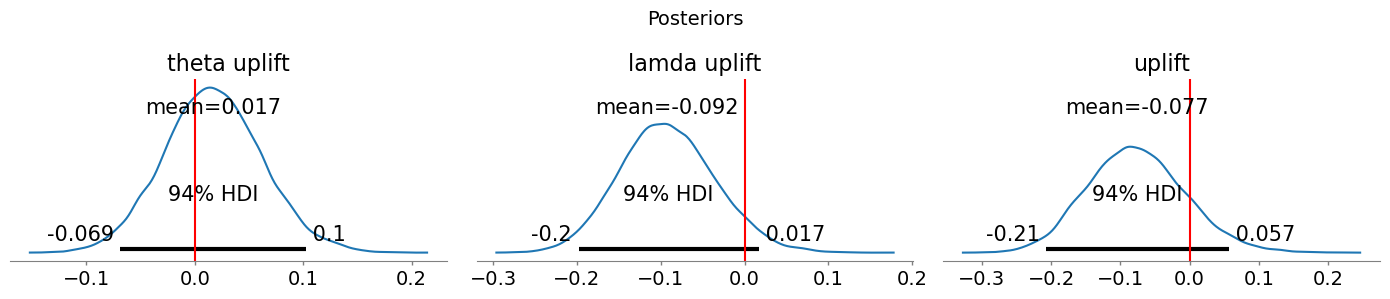

In [11]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i],)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

<div class="alert alert-info">
<h4>Task 1</h4>

Check out the posterior distributions, especially the HDI, if it includes zero, and the sign of the mean. Then answer the following questions:

- What do you learn from the posterior distribution of uplift for $\theta$?

- What do you learn from the posterior distribution of uplift for $\lambda$?

- What do you learn from the posterior distribution of uplift for $\frac{\theta}{\lambda}$? did you expect its HDI to include zero?
<br>
</div>



write your answer here

**Answer:**

1. $\theta_A$ and $\theta_B$ represent the posterior distribution of the conversion rates for variant A and B respectively. The uplift represents the posterior distribution of the difference between $\theta_A$ and $\theta_B$. The shapes of the converation rates is (4000, 2) meaning that we have 4000 samples for $\theta_A$ and $\theta_B$ respectively. The shape of the uplift is (4000,) meaning that we have 4000 samples for the difference between $\theta_A$ and $\theta_B$.

2. We have 4000 samples because we have 4 chains and 1000 samples per chain. The default number of chains is 4.

Let's continue by exploring the posterior distributions.

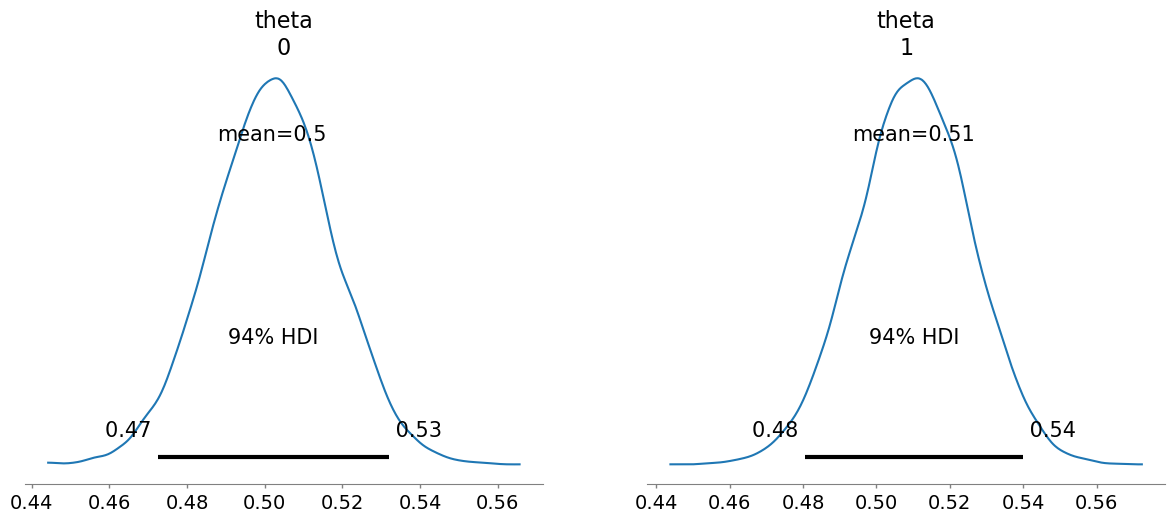

In [12]:
# plot the posterior of the conversion rates
az.plot_posterior(trace, var_names=["theta"]);

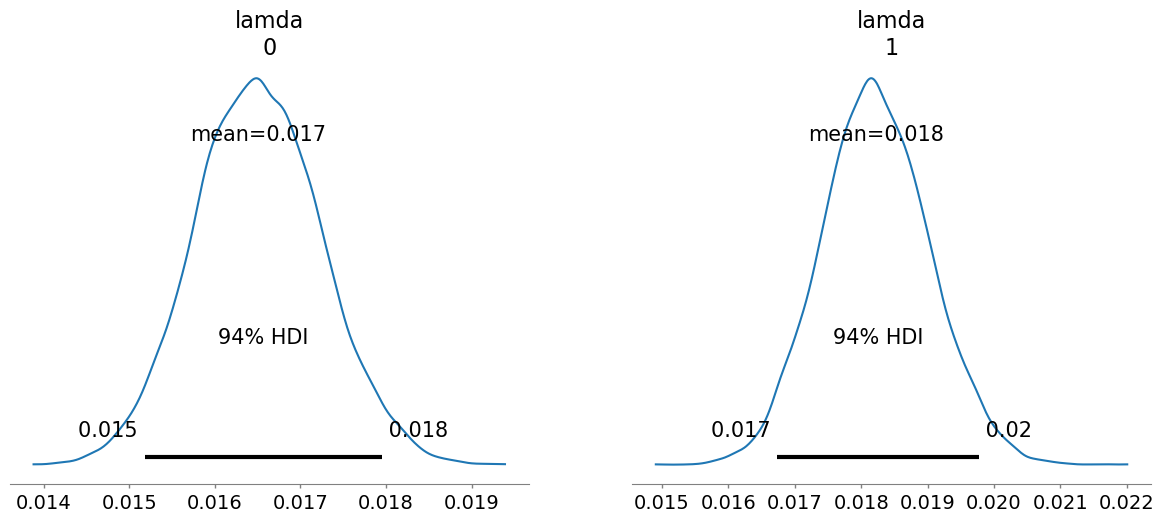

In [13]:
# plot the posterior of the mean purchase
az.plot_posterior(trace, var_names=["lamda"]);

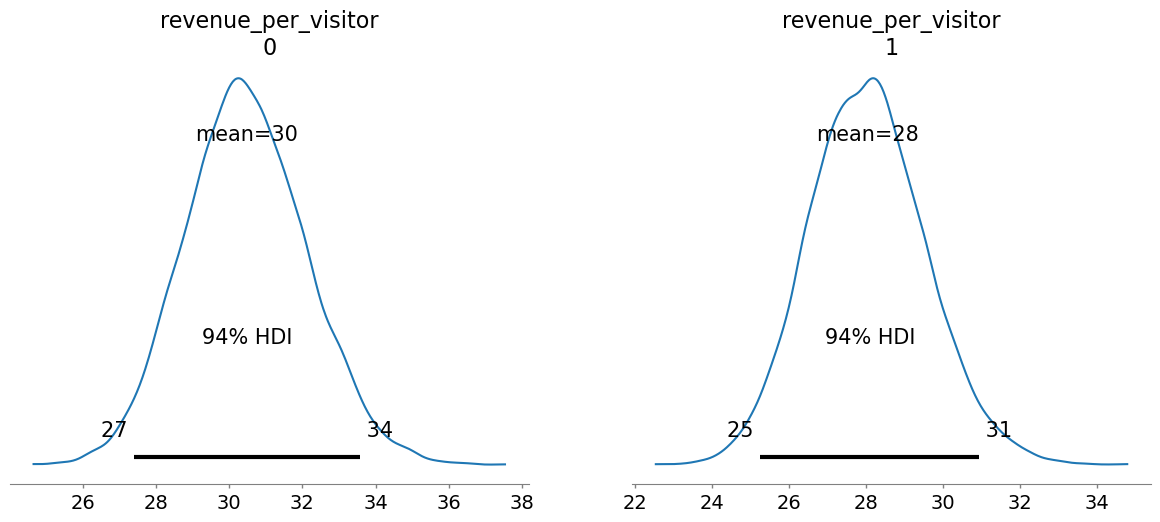

In [14]:
# plot the posterior of the mean purchase
az.plot_posterior(trace, var_names=["revenue_per_visitor"]);

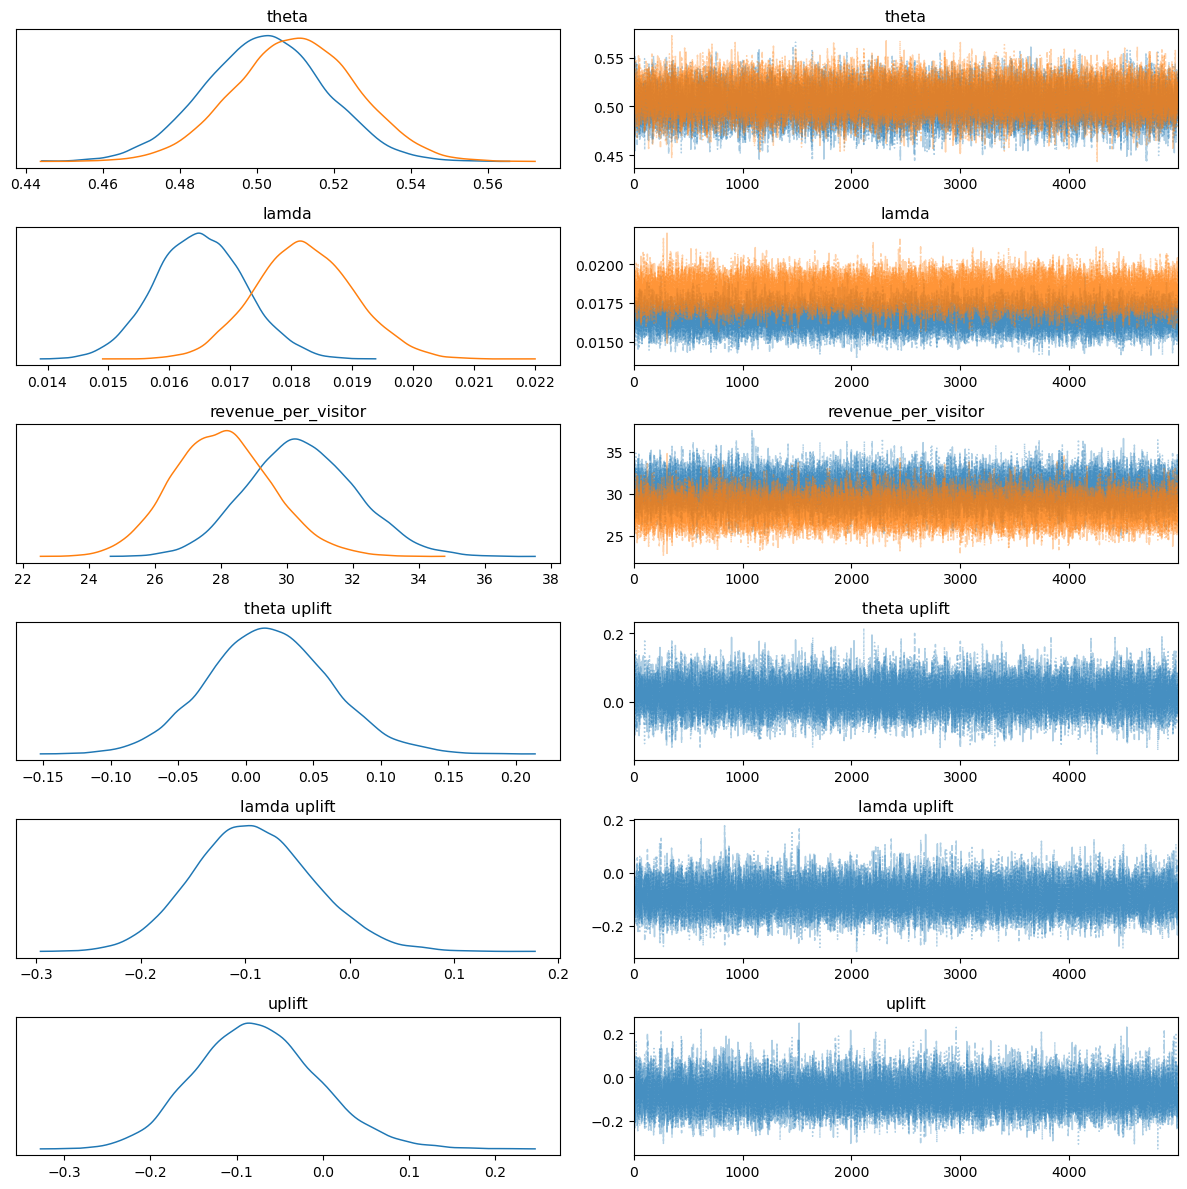

In [17]:
# plot all posterior distributions
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

## Your Second Try

Note that so far we have set up the number of `conversion` and `total_revenue` as absolute values. We will now change them to be random variables. 

To generate them as random variables, we need to specify `conversion_rates` and `mean_purchase`. To see how to do this you can check the `get_data` function in the `tools.py` file in the same directory.

In [53]:
%run -i tools.py

Let's suppose that variant B's visitors are less likely to purchase: $$\theta_B=8\% < \theta_A=10\%$$

But their mean purchase value is higher: 

$$\frac{1}{\lambda_B}=12.5 > \frac{1}{\lambda_A}=10$$

Remember that the expected revenue per visitor was $\frac{\theta}{\lambda}$. So, in this scenario both variants have the same expected revenue per visitor:

$$ 0.08 \times 12.5 =  0.10 \times 10$$

Therefore, the relative uplift should be zero because 

$$\mathrm{uplift} = \frac{0.08 \times 12.5}{0.10 \times 10} - 1 = 0$$


In [45]:
# let's increase the sample size to 100,000 
visitors = [100000, 100000]

# conversion_rates [10%, 8%]  
conversion_rates = [0.1, 0.08]

# mean_purchase 
mean_purchase    = [10, 12.5]

In [46]:
purchased, total_revenue = get_data(['A', 'B'], conversion_rates, mean_purchase, 100000)

generated 100000 obs from a Bernoulli rv based on 0.1 rate for variant A
generated 100000 obs from an Exponential rv based on 10 for variant A
----------------------------------------------------------------------
generated 100000 obs from a Bernoulli rv based on 0.08 rate for variant B
generated 100000 obs from an Exponential rv based on 12.5 for variant B
----------------------------------------------------------------------

 Below is the outcome and we are now going to use them as input in the PyMC model:


,A,B
visitors,100000.0,100000.0
purchased,10063.0,8018.0
total_revenue,99501.0,100412.0


Let's keep the priors the same as before:

In [47]:
# let's define parameters for a weak prior for the conversion rates
conv_alpha, conv_beta = [5000, 5000]

# let's define parameters for the mean purchase prior
purchase_alpha, purchase_beta = [9000, 900]

In [50]:
trace =  get_posterior2(beta_priors  = [conv_alpha, conv_beta], 
                        gamma_priors = [purchase_alpha, purchase_beta],
                        visitors     = 100000, 
                        purchased    = purchased,
                        total_revenue= total_revenue)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lamda]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.


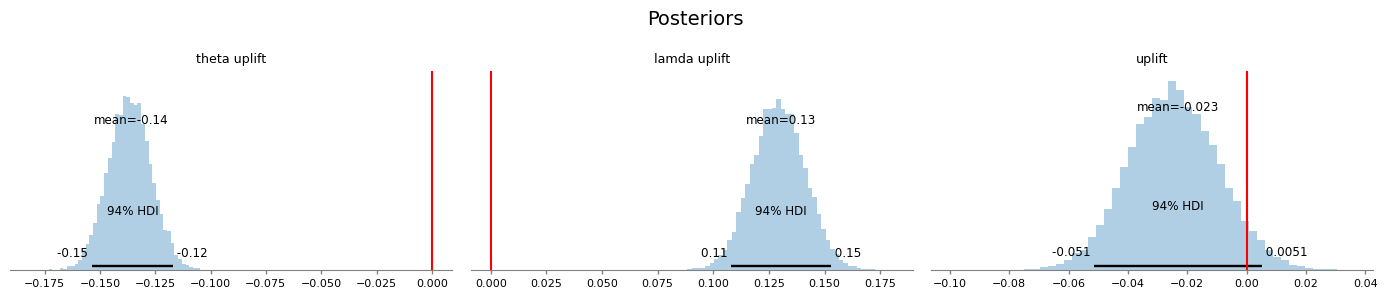

In [51]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **pvars)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

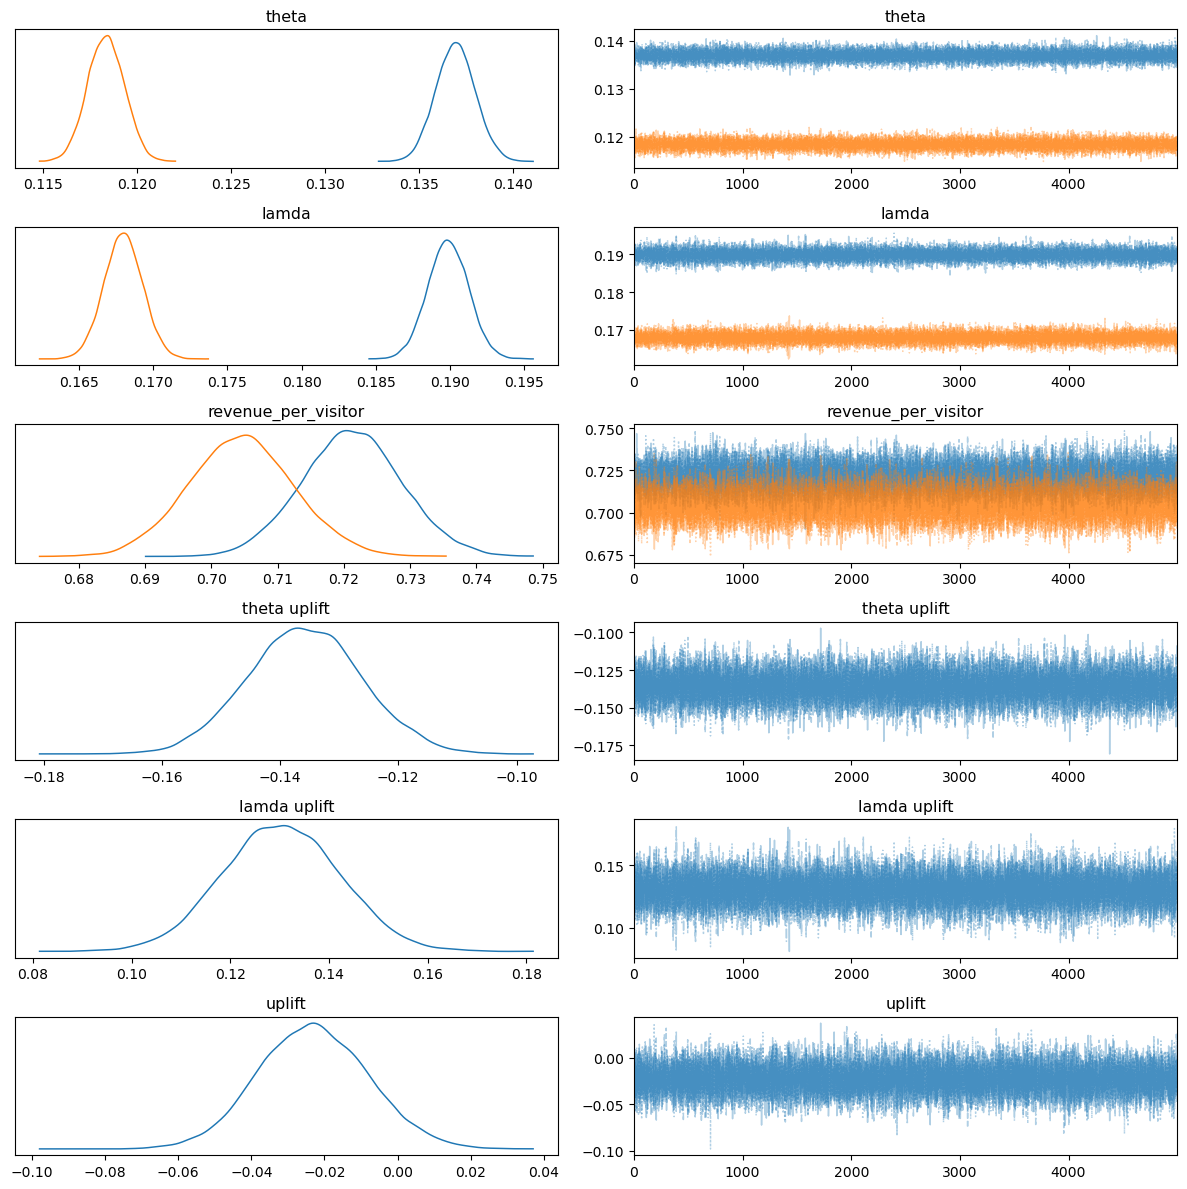

In [52]:
# plot all posterior distributions
az.plot_trace(trace, compact=True, combined=True)
plt.tight_layout();

## Your third Try
Higher propensity to purchase and higher mean purchase value, and overall higher revenue per visitor

Let's suppose that variant B's visitors are more likely to purchase: $$\theta_B=11\% > \theta_A=10\%$$

And their mean purchase value is higher: 

$$\frac{1}{\lambda_B}=10.5 > \frac{1}{\lambda_A}=10$$

Remember that the expected revenue per visitor was $\frac{\theta}{\lambda}$. So, in this scenario both variants have the same expected revenue per visitor:

$$ 0.11 \times 10.5 >  0.10 \times 10$$

Therefore, the relative uplift should be zero because 

$$\mathrm{uplift} = \frac{1.155}{1} - 1 > 0$$


In [54]:
# conversion_rates [10%, 11%]  
conversion_rates = [0.1, 0.11]

# mean_purchase 
mean_purchase    = [10, 10.5]

In [55]:
purchased, total_revenue = get_data(['A', 'B'], conversion_rates, mean_purchase, 100000)

generated 100000 obs from a Bernoulli rv based on 0.1 rate for variant A
generated 100000 obs from an Exponential rv based on 10 for variant A
----------------------------------------------------------------------
generated 100000 obs from a Bernoulli rv based on 0.11 rate for variant B
generated 100000 obs from an Exponential rv based on 10.5 for variant B
----------------------------------------------------------------------

 Below is the outcome and we are now going to use them as input in the PyMC model:


,A,B
visitors,100000.0,100000.0
purchased,10144.0,11057.0
total_revenue,101892.0,116364.0


In [56]:
trace =  get_posterior2(beta_priors  = [conv_alpha, conv_beta], 
                        gamma_priors = [purchase_alpha, purchase_beta],
                        visitors     = 100000, 
                        purchased    = purchased,
                        total_revenue= total_revenue
                        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [theta, lamda]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.


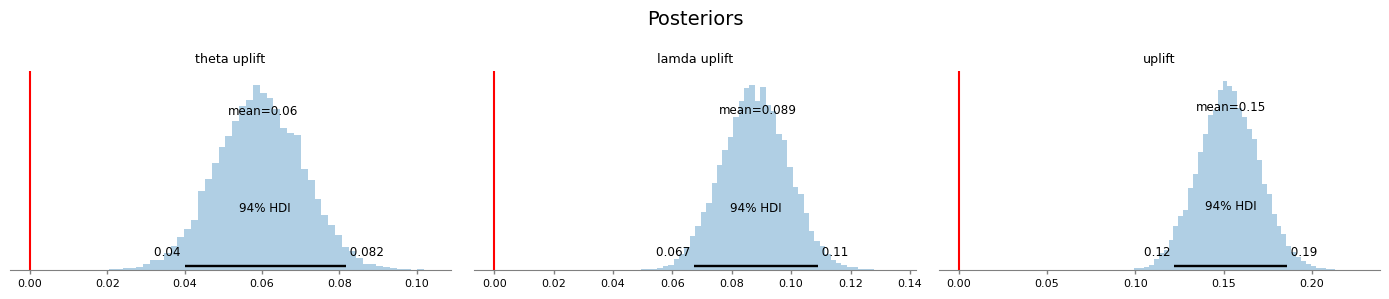

In [57]:
# plot all the three uplifts 
fig, axes = plt.subplots(1,3, figsize=(14,3), sharey=True)
fig.suptitle("Posteriors", fontsize=14)

for i, var in enumerate(["theta uplift", "lamda uplift", "uplift"]):
    az.plot_posterior(trace.posterior[var], ax=axes[i], **pvars)
    axes[i].axvline(x=0, color="red")

plt.tight_layout()
plt.show()

<div class="alert alert-info">
<h3>Task 2</h3>

- What do you learn from the posterior distribution of uplift for $\theta$?

- What do you learn from the posterior distribution of uplift for $\lambda$?

- What do you learn from the posterior distribution of uplift for $\frac{\theta}{\lambda}$? did you expect its HDI not containig zero?
<br>
</div>

Assumption: 

- conversion probability is independent to the mean amount spent when paying. This is a typical assumption in practice
